In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_excel("DAGs Data.xlsx", index_col = [31, 38])
data.rename(columns={key: str(key).replace("_", " ").title() for key in data}, inplace= True)
data["General Outcome"][data["Environmental Outcome"]==1]=1
data["General Outcome"][data["Health Outcome"]==1]=1
keys = list(data.keys())

/Users/kodjobarnor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/Users/kodjobarnor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [3]:
years = keys[-31:]
countries = keys[-82:-31]
data.rename(columns = {year:str(year) for year in years}, inplace = True)
years = [str(year) for year in years]

In [4]:
keys =["General Outcome",
       #'Num Citations',
       "Impact F Publishing Year",
      "Private",
      "Public",
       "International",
       "University",
      #'Private Affiliation',
      #'Public Affiliation',
      #'University Affiliation'
      ]
keys = keys #+ countries
#keys = ["General_outcome", "Year", "Fund_Source", "Loc_experiment", "Journal"]
max_cond_vars = len(keys) - 2
data_reg = data[keys].dropna()
data_reg["Impact F Publishing Year"] = data_reg["Impact F Publishing Year"].astype(float)

In [5]:
import pingouin
from pgmpy.estimators import PC
c = PC(data_reg[keys].dropna())
max_cond_vars = len(keys) - 2

sig =0.05
model = c.estimate(return_type = "dag", variant= "parallel", 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()
pcorr = data_reg.pcorr()
weights = {}

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
pcorr

,General Outcome,Impact F Publishing Year,Private,Public,International,University
General Outcome,1.000000,0.100055,-0.076359,0.049558,-0.042889,0.055925
Impact F Publishing Year,0.100055,1.000000,0.117103,0.192857,0.141413,0.050401
Private,-0.076359,0.117103,1.000000,-0.138252,-0.090557,-0.166505
Public,0.049558,0.192857,-0.138252,1.000000,-0.142227,-0.027973
International,-0.042889,0.141413,-0.090557,-0.142227,1.000000,-0.066431
University,0.055925,0.050401,-0.166505,-0.027973,-0.066431,1.000000


In [7]:
undirected_graph = {key:[] for key in data_reg.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in data_reg.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

OutEdgeView([('International', 'Impact F Publishing Year'), ('Public', 'Impact F Publishing Year'), ('Public', 'International'), ('General Outcome', 'Impact F Publishing Year'), ('University', 'Private')])

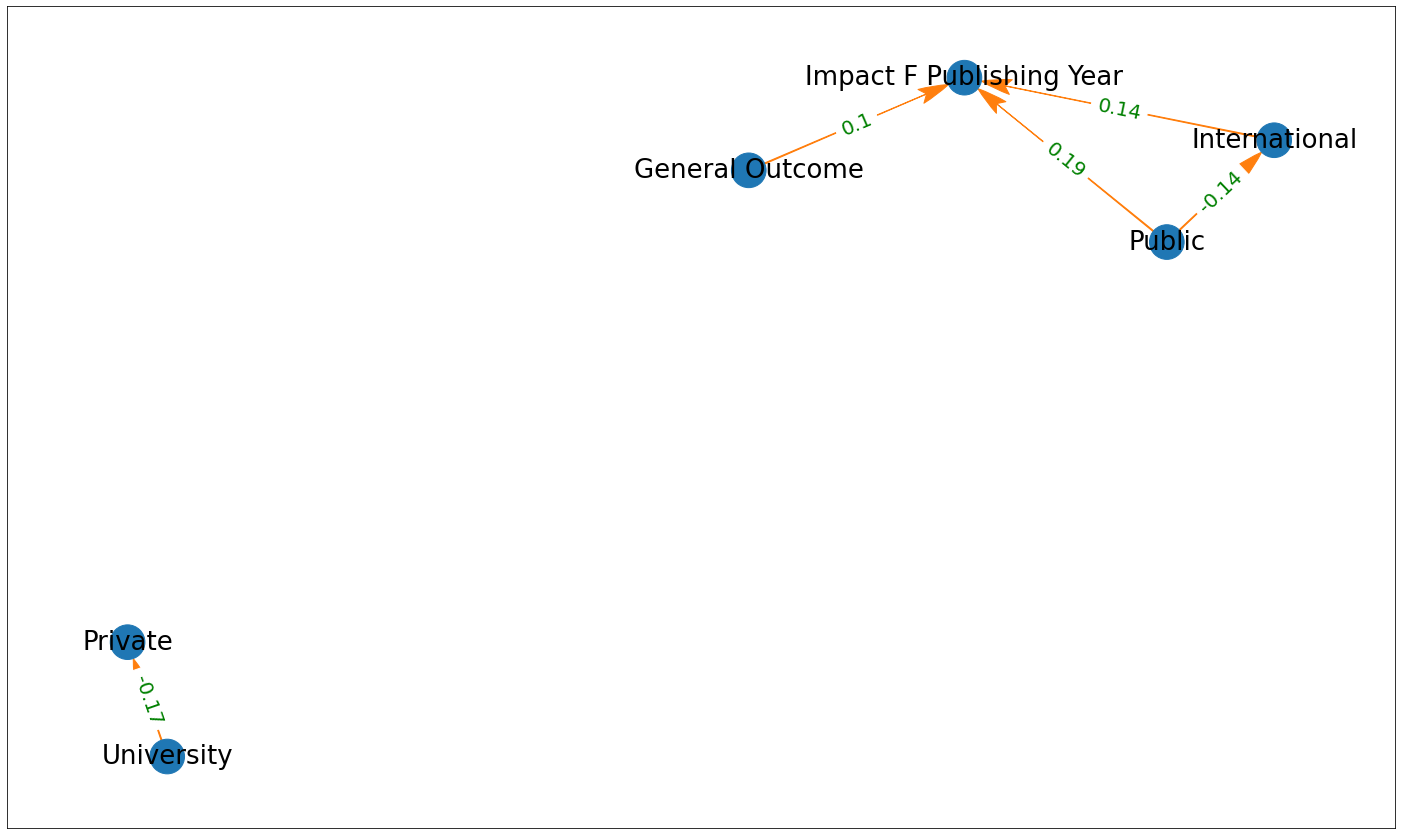

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
def graph_DAG(edges, data_reg, title = ""):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
plt.close()
graph_DAG(edges, data_reg)
edges

In [9]:
X_vars = ["General Outcome",
      "Public",
       "International"]
y_var = ["Impact F Publishing Year"]

In [10]:
import statsmodels.api as sm
import numpy
residuals = {}
partial_corr = {}
reg_df = data_reg[keys].dropna()[:-1]
X= reg_df[X_vars]
X["constant"] = 1
y = reg_df[y_var]
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())
predict = results.predict()
reg_df["predict"] = predict
#residuals[y_var] = results.resid

                               OLS Regression Results                               
Dep. Variable:     Impact F Publishing Year   R-squared:                       0.054
Model:                                  OLS   Adj. R-squared:                  0.048
Method:                       Least Squares   F-statistic:                     9.007
Date:                      Fri, 05 Nov 2021   Prob (F-statistic):           8.24e-06
Time:                              10:04:09   Log-Likelihood:                -912.67
No. Observations:                       476   AIC:                             1833.
Df Residuals:                           472   BIC:                             1850.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

<ipython-input-10-5fbb7ac6eb7e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["constant"] = 1


In [11]:
data_dict = {}  
data_dict["Data"] = data_reg 

In [12]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [13]:
exog_vars = np.nan_to_num(X_vars)
dep_var = np.nan_to_num(y_var)

In [14]:
exog = sm.add_constant(data[exog_vars])
mod = RandomEffects(data[dep_var], exog)
re_res = mod.fit()
print(re_res)

                           RandomEffects Estimation Summary                           
Dep. Variable:     Impact F Publishing Year   R-squared:                        0.1760
Estimator:                    RandomEffects   R-squared (Between):              0.1588
No. Observations:                       477   R-squared (Within):               0.0583
Date:                      Fri, Nov 05 2021   R-squared (Overall):              0.0514
Time:                              10:04:09   Log-likelihood                   -895.69
Cov. Estimator:                  Unadjusted                                           
                                              F-statistic:                      33.678
Entities:                                53   P-value                           0.0000
Avg Obs:                             9.0000   Distribution:                   F(3,473)
Min Obs:                             1.0000                                           
Max Obs:                             94.000

/Users/kodjobarnor/opt/anaconda3/lib/python3.8/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [15]:
from linearmodels import PanelOLS
X_vars = ["General Outcome",
      "Public",
       "International"]
y_var = ["Impact F Publishing Year"]
for key, data in data_dict.items():
    for entity in [True, False]:
        for time in [True, False]:
#             X_vars = [x for x in keys if x != y_var]
            X= reg_df[X_vars]
            y = reg_df[y_var]
            print(key)
            print("Entity =", entity)
            print("Time =", time)
            reg_data = data_dict[key].dropna()
            Y = reg_data[y_var]
            X = reg_data[X_vars]
            X["Constant"] = 1
            # call panel_regression method        
            model = PanelOLS(Y,X, entity_effects=entity, time_effects=time)
            results = model.fit(cov_type='clustered', cluster_entity=True)
            print(key, results, sep ="\n") 
            #reg_data["Predictor"] = results.predict()
            #reg_data["Residuals"] = reg_data[y_name[0]].sub(reg_data["Predictor"])

<ipython-input-15-e0b6cf2527db>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1


Data
Entity = True
Time = True
Data
                             PanelOLS Estimation Summary                              
Dep. Variable:     Impact F Publishing Year   R-squared:                        0.0415
Estimator:                         PanelOLS   R-squared (Between):              0.1133
No. Observations:                       477   R-squared (Within):               0.0570
Date:                      Fri, Nov 05 2021   R-squared (Overall):              0.0513
Time:                              10:04:09   Log-likelihood                   -822.86
Cov. Estimator:                   Clustered                                           
                                              F-statistic:                      5.7396
Entities:                                54   P-value                           0.0007
Avg Obs:                             8.8333   Distribution:                   F(3,398)
Min Obs:                             0.0000                                           
Max Obs

<ipython-input-15-e0b6cf2527db>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
<ipython-input-15-e0b6cf2527db>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1


Data
                             PanelOLS Estimation Summary                              
Dep. Variable:     Impact F Publishing Year   R-squared:                        0.0453
Estimator:                         PanelOLS   R-squared (Between):              0.1638
No. Observations:                       477   R-squared (Within):               0.0498
Date:                      Fri, Nov 05 2021   R-squared (Overall):              0.0522
Time:                              10:04:09   Log-likelihood                   -870.39
Cov. Estimator:                   Clustered                                           
                                              F-statistic:                      7.1142
Entities:                                54   P-value                           0.0001
Avg Obs:                             8.8333   Distribution:                   F(3,450)
Min Obs:                             0.0000                                           
Max Obs:                             9

<ipython-input-15-e0b6cf2527db>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Constant"] = 1
